##### Derivative Computation of the LiDAR scan data
       By computing the derivative of the raw LiDAR data, the left edge and right edge of the landmarks (Cylinders) can be identified.

In [1]:
import matplotlib.pyplot as plt
from lego_robot import *
from math import sin, cos

# Find the derivative in scan data, ignoring invalid measurements.
def compute_derivative(scan, min_dist):
    jumps = [ 0 ]
    for i in xrange(1, len(scan) - 1):
        l = scan[i-1]
        r = scan[i+1]
        if l > min_dist and r > min_dist:
            derivative = (r - l) / 2.0
            jumps.append(derivative)
        else:
            jumps.append(0)
    jumps.append(0)
    return jumps

##### Identification of Landmarks from the LiDAR scan data.
    Alogorithm to find the landmarks (cylinders).

In [2]:
def find_cylinders(scan, scan_derivative, jump, min_dist):
    cylinder_list = []
    on_cylinder = False
    sum_ray, sum_depth, rays = 0.0, 0.0, 0

    for i in xrange(len(scan_derivative)):

        if (scan_derivative[i] < -jump):
            on_cylinder = True
            rays = 0
            sum_ray = 0.0
            sum_depth = 0
    
    
        elif (scan_derivative[i] > jump and on_cylinder):
            on_cylinder = False
            rays += 1
            sum_ray += i
            sum_depth += scan[i]
            cylinder_list.append((sum_ray/rays, sum_depth/rays))
            
                
        if (on_cylinder and scan[i] > min_dist):
            rays += 1
            sum_ray += i
            sum_depth += scan[i]

    return cylinder_list

##### Cartesian Coordinates
    Converting the positions of the cylinder to cartesian coordinates in the robotics coordinate system

In [3]:
def compute_cartesian_coordinates(cylinders, cylinder_offset):
    result = []
    for c in cylinders:
        beam_angle = LegoLogfile.beam_index_to_angle(c[0])
        r = c[1] + cylinder_offset
        result.append( (r*cos(beam_angle), r*sin(beam_angle)) ) # Replace this by your (x,y)
    return result

##### Plots
    Example plots which show the derivative and the identification of the landmarks.

In [4]:
def example_plot(scan_no):

    
    scan_to_plot = logfile.scan_data[scan_no]
    der_to_plot = compute_derivative(scan_to_plot, minimum_valid_distance)
    cyl_to_plot = cylinders = find_cylinders(scan_to_plot, der_to_plot, depth_jump,
                                   minimum_valid_distance)
    # Plot results.
    plt.figure(0)
    plt.title("Example derivative plot of scan %d" % scan_no)
    plt.plot(scan_to_plot)
    plt.plot(der_to_plot)
    plt.show()
    
    plt.figure(2)
    plt.title("Found Cylinders in scan %d"% scan_no)
    plt.plot(scan_to_plot)
    plt.scatter([c[0] for c in cylinders], [c[1] for c in cylinders],
            c='r', s=200)
    plt.show()

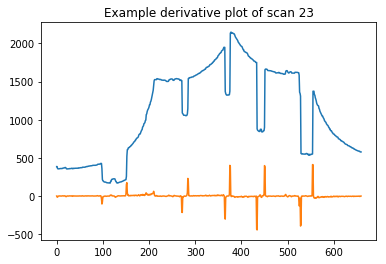

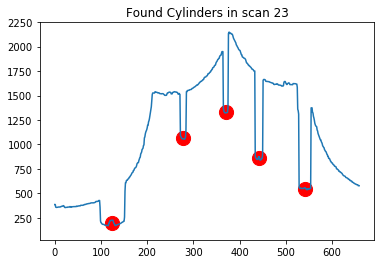

In [5]:
if __name__ == '__main__':

    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_scan.txt")
    
    # Pick one scan for an example plot
    scan_no = 23
    example_plot(scan_no)
    
    # Write a result file containing all cylinder records.
    # Format is: D C x[in mm] y[in mm] ...
    # With zero or more points.
    # Note "D C" is also written for otherwise empty lines (no
    # cylinders in scan)
    out_file = file("cylinders.txt", "w")
    for scan in logfile.scan_data:
        # Find cylinders.
        der = compute_derivative(scan, minimum_valid_distance)
        cylinders = find_cylinders(scan, der, depth_jump,
                                   minimum_valid_distance)
        cartesian_cylinders = compute_cartesian_coordinates(cylinders,
                                                            cylinder_offset)
        # Write to file.
        out_file.write("D C ")
        for c in cartesian_cylinders:
            out_file.write("%.1f %.1f " % c)
        out_file.write("\n")
    out_file.close()